In [340]:
from __future__ import division
import math
import pickle
import requests
import numpy as np
import tensorflow as tf
from itertools import product
from random import sample
from string import lowercase
# from captcha.image import ImageCaptcha

In [2]:
from StringIO import StringIO
import tempfile
from PIL import Image
import py4j
from py4j.java_gateway import JavaGateway, GatewayParameters

### .初始化验证生成控件

In [29]:
port = py4j.java_gateway.launch_gateway(classpath='/usr/lib/jvm/lib/kaptcha-2.3.2.jar')
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=port))
constants = gateway.jvm.com.google.code.kaptcha.Constants
ImageIO = gateway.jvm.javax.imageio.ImageIO
filename = tempfile.mktemp(suffix='.jpg')

In [30]:
fontSizeList = ['39', '40', '41', '42', '43', '44', '45']
fontNameList = [
    'Ubuntu Light',
    'Ubuntu Light Italic',
    'Ubuntu Regular',
    'Ubuntu Regular Italic',
    'Lato-Hairline',
    'lmroman8-italic', 
    'lmmonocaps10-regular',
    'Loma-Oblique',
    'Norasi-Oblique',
    'Umpush-Light',
]
kaptchaList = []
for fontSize, fontName in product(fontSizeList, fontNameList):
    properties = gateway.jvm.java.util.Properties()
    properties.put(constants.KAPTCHA_IMAGE_WIDTH, '223')
    properties.put(constants.KAPTCHA_IMAGE_HEIGHT, '50')
    properties.put(constants.KAPTCHA_TEXTPRODUCER_FONT_SIZE, fontSize)
    properties.put(constants.KAPTCHA_TEXTPRODUCER_FONT_NAMES, fontName)
    properties.put(constants.KAPTCHA_BORDER, 'no')
    kaptchaConfig = gateway.jvm.com.google.code.kaptcha.util.Config(properties)
    kaptcha = gateway.jvm.com.google.code.kaptcha.impl.DefaultKaptcha()
    kaptcha.setConfig(kaptchaConfig)
    kaptchaList.append(kaptcha)

### .定义模型参数

In [383]:
width = 223
height = 50
# charset = '0123456789'
# charset = '0123456789' + lowercase
charset = digits + lowercase
# captchaLength = 4
captchaLength = 1
index = 0
imageSize = width * height
alpha = 1e-3

### .定义相关函数

In [6]:
# def getCode():
#     return ''.join(map(
#         lambda x: charset[x], 
#         # np.random.randint(0, len(charset), captchaLength)  
#         np.random.randint(0, len(charset), 4) # changed
#     ))
# captcha = ImageCaptcha(width=width, height=height)

In [7]:
# def getData(n = 10):    
#     codeList = [getCode() for _ in range(n)]
#     imageList = map(lambda code: captcha.generate_image(code), codeList)
#     return imageList, codeList

In [8]:
def getCode():
    return kaptcha.createText()

In [9]:
def generateImage(code):
    kaptcha = sample(kaptchaList, 1)[0]
    image = kaptcha.createImage(code)
    f = gateway.jvm.java.io.File(filename)    
    ImageIO.write(image, 'JPG', f)
    image = Image.open(filename)
    return image

In [10]:
def getData(n = 10):    
    codeList = [getCode() for _ in range(n)]
    imageList = map(lambda code: generateImage(code), codeList)
    return imageList, codeList

In [11]:
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.01)                                                                                                     
    return tf.Variable(initial)   

In [12]:
def bias_variable(shape):
    initial = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(initial)   

In [13]:
def conv2d(x, W): 
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [14]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [15]:
# def imageToVertor(image):
#     """ 将图片转化为向量表示 """
#     image = image.convert("L")
#     image = np.asarray(image)
#     image = image.reshape([width * height]) / 255
#     return image

In [358]:
def imageToVertor(image):
    """ 将图片转化为向量表示 """
    width = image.width
    height = image.height
    image = image.convert("L")
    image = np.asarray(image)
    image = image.reshape([width * height]) / 255
    return image

In [16]:
def codeToVertor(code):
    """ 将验证码转化为向量表示 """
    labels = np.zeros([captchaLength, len(charset)])
    for i in range(captchaLength):
        labels[i, charset.index(code[i])] = 1
    return labels.reshape(len(charset) * captchaLength)

b645g


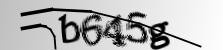

In [17]:
# 测试验证码
code = getCode()
print code
generateImage(code)

### .定义神经网络结构

In [18]:
# 定义输入输出
x = tf.placeholder(tf.float32, shape=[None, imageSize])
y = tf.placeholder(tf.float32, shape=[None, len(charset) * captchaLength])   
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(x, shape=[-1, width, height, 1])

In [19]:
# 定义第一层卷积
conv_layer1_weight = weight_variable([5, 5, 1, 32])
conv_layer1_bias = bias_variable([32])
pool_layer1 = max_pool(
    tf.nn.relu(conv2d(x_image, conv_layer1_weight) + conv_layer1_bias))

In [20]:
# 定义第二层卷积
conv_layer2_weight = weight_variable([5, 5, 32, 64])
conv_layer2_bias = bias_variable([64])
pool_layer2 = max_pool(
    tf.nn.relu(conv2d(pool_layer1, conv_layer2_weight) + conv_layer2_bias)) 

In [21]:
# 定义第三层卷积
conv_layer3_weight = weight_variable([5, 5, 64, 64])
conv_layer3_bias = bias_variable([64])
pool_layer3 = max_pool(
    tf.nn.relu(conv2d(pool_layer2, conv_layer3_weight) + conv_layer3_bias))

In [22]:
lastWidth = int(math.ceil(width / 8))
lastHeight = int(math.ceil(height / 8))
lastWidth, lastHeight

(28, 7)

In [23]:
# 定义全连接层
fc_layer_weight = weight_variable([lastWidth * lastHeight * 64, 1024])
fc_layer_bias = bias_variable([1024])
pool_layer3_flat = tf.reshape(pool_layer3, [-1, lastWidth * lastHeight * 64])
fc_layer = tf.nn.relu(tf.add(tf.matmul(pool_layer3_flat, fc_layer_weight), fc_layer_bias))

In [24]:
# Dropout层
fc_layer_drop = tf.nn.dropout(fc_layer, keep_prob)

In [25]:
# Readout层(输出层)
output_layer_weight = weight_variable([1024, len(charset) * captchaLength])   
output_layer_bias = bias_variable([len(charset) * captchaLength])              
y_conv = tf.add(tf.matmul(fc_layer_drop, output_layer_weight), output_layer_bias)

In [26]:
# 定义输出函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_conv))
optimizer = tf.train.AdamOptimizer(alpha).minimize(loss)
prediction = tf.argmax(tf.reshape(y_conv, [-1, captchaLength, len(charset)]), 2)
correct = tf.argmax(tf.reshape(y, [-1, captchaLength, len(charset)]), 2)                                                           
correct_prediction = tf.equal(prediction, correct)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### .训练模型

In [27]:
# 初始化session
saver = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [28]:
for step in range(1, 3000):
    imageList, codeList = getData(100)
    codeList = map(lambda x: x[index], codeList) # changed 
    x_data = map(imageToVertor, imageList)
    y_data = map(codeToVertor, codeList)
    _, l, a = session.run([optimizer, loss, accuracy], feed_dict={x: x_data, y: y_data, keep_prob: .75})
    saver.save(session, 'model/%s/model' % index, global_step=step)
    print '[%d]: loss: %f accuracy: %f' % (step, l, a)

[1]: loss: 0.683238 accuracy: 0.060000
[2]: loss: 0.524541 accuracy: 0.030000
[3]: loss: 0.217826 accuracy: 0.050000
[4]: loss: 0.174370 accuracy: 0.040000
[5]: loss: 0.236467 accuracy: 0.090000
[6]: loss: 0.208725 accuracy: 0.090000
[7]: loss: 0.146154 accuracy: 0.100000
[8]: loss: 0.126768 accuracy: 0.070000
[9]: loss: 0.142963 accuracy: 0.070000
[10]: loss: 0.145149 accuracy: 0.100000
[11]: loss: 0.134664 accuracy: 0.040000
[12]: loss: 0.123366 accuracy: 0.040000
[13]: loss: 0.114932 accuracy: 0.050000
[14]: loss: 0.116765 accuracy: 0.050000
[15]: loss: 0.122427 accuracy: 0.070000
[16]: loss: 0.125894 accuracy: 0.040000
[17]: loss: 0.126350 accuracy: 0.050000
[18]: loss: 0.122288 accuracy: 0.080000
[19]: loss: 0.117624 accuracy: 0.120000
[20]: loss: 0.115709 accuracy: 0.060000
[21]: loss: 0.116033 accuracy: 0.090000
[22]: loss: 0.112647 accuracy: 0.070000
[23]: loss: 0.112343 accuracy: 0.120000
[24]: loss: 0.115360 accuracy: 0.060000
[25]: loss: 0.114704 accuracy: 0.110000
[26]: los

[204]: loss: 0.110694 accuracy: 0.080000
[205]: loss: 0.110398 accuracy: 0.100000
[206]: loss: 0.110324 accuracy: 0.120000
[207]: loss: 0.111189 accuracy: 0.110000
[208]: loss: 0.110828 accuracy: 0.080000
[209]: loss: 0.110447 accuracy: 0.120000
[210]: loss: 0.111661 accuracy: 0.100000
[211]: loss: 0.110182 accuracy: 0.100000
[212]: loss: 0.113062 accuracy: 0.050000
[213]: loss: 0.109539 accuracy: 0.150000
[214]: loss: 0.110423 accuracy: 0.120000
[215]: loss: 0.111622 accuracy: 0.070000
[216]: loss: 0.110068 accuracy: 0.070000
[217]: loss: 0.110214 accuracy: 0.110000
[218]: loss: 0.111143 accuracy: 0.110000
[219]: loss: 0.110607 accuracy: 0.110000
[220]: loss: 0.109971 accuracy: 0.110000
[221]: loss: 0.111202 accuracy: 0.040000
[222]: loss: 0.112886 accuracy: 0.040000
[223]: loss: 0.110631 accuracy: 0.100000
[224]: loss: 0.112085 accuracy: 0.060000
[225]: loss: 0.110408 accuracy: 0.100000
[226]: loss: 0.112569 accuracy: 0.040000
[227]: loss: 0.110479 accuracy: 0.050000
[228]: loss: 0.1

[404]: loss: 0.110863 accuracy: 0.080000
[405]: loss: 0.110665 accuracy: 0.070000
[406]: loss: 0.111050 accuracy: 0.080000
[407]: loss: 0.110168 accuracy: 0.070000
[408]: loss: 0.109963 accuracy: 0.080000
[409]: loss: 0.110020 accuracy: 0.090000
[410]: loss: 0.110387 accuracy: 0.090000
[411]: loss: 0.110781 accuracy: 0.080000
[412]: loss: 0.109265 accuracy: 0.100000
[413]: loss: 0.109663 accuracy: 0.120000
[414]: loss: 0.109963 accuracy: 0.120000
[415]: loss: 0.110790 accuracy: 0.080000
[416]: loss: 0.109938 accuracy: 0.120000
[417]: loss: 0.109841 accuracy: 0.140000
[418]: loss: 0.111498 accuracy: 0.080000
[419]: loss: 0.109433 accuracy: 0.120000
[420]: loss: 0.110331 accuracy: 0.090000
[421]: loss: 0.111027 accuracy: 0.050000
[422]: loss: 0.110527 accuracy: 0.090000
[423]: loss: 0.110664 accuracy: 0.080000
[424]: loss: 0.109649 accuracy: 0.110000
[425]: loss: 0.109928 accuracy: 0.050000
[426]: loss: 0.109251 accuracy: 0.100000
[427]: loss: 0.110067 accuracy: 0.060000
[428]: loss: 0.1

[604]: loss: 0.104966 accuracy: 0.160000
[605]: loss: 0.107317 accuracy: 0.090000
[606]: loss: 0.107561 accuracy: 0.090000
[607]: loss: 0.106198 accuracy: 0.120000
[608]: loss: 0.108799 accuracy: 0.120000
[609]: loss: 0.105771 accuracy: 0.120000
[610]: loss: 0.109260 accuracy: 0.080000
[611]: loss: 0.108174 accuracy: 0.070000
[612]: loss: 0.105291 accuracy: 0.140000
[613]: loss: 0.109284 accuracy: 0.040000
[614]: loss: 0.106220 accuracy: 0.090000
[615]: loss: 0.107293 accuracy: 0.140000
[616]: loss: 0.105993 accuracy: 0.110000
[617]: loss: 0.106925 accuracy: 0.130000
[618]: loss: 0.105508 accuracy: 0.130000
[619]: loss: 0.107168 accuracy: 0.090000
[620]: loss: 0.102575 accuracy: 0.130000
[621]: loss: 0.108117 accuracy: 0.090000
[622]: loss: 0.106447 accuracy: 0.170000
[623]: loss: 0.106328 accuracy: 0.100000
[624]: loss: 0.105037 accuracy: 0.130000
[625]: loss: 0.103733 accuracy: 0.200000
[626]: loss: 0.106076 accuracy: 0.080000
[627]: loss: 0.103153 accuracy: 0.150000
[628]: loss: 0.1

[804]: loss: 0.071764 accuracy: 0.470000
[805]: loss: 0.071836 accuracy: 0.450000
[806]: loss: 0.080630 accuracy: 0.400000
[807]: loss: 0.068829 accuracy: 0.550000
[808]: loss: 0.068502 accuracy: 0.500000
[809]: loss: 0.070809 accuracy: 0.490000
[810]: loss: 0.068153 accuracy: 0.520000
[811]: loss: 0.074990 accuracy: 0.460000
[812]: loss: 0.073390 accuracy: 0.490000
[813]: loss: 0.065561 accuracy: 0.540000
[814]: loss: 0.076433 accuracy: 0.420000
[815]: loss: 0.073803 accuracy: 0.470000
[816]: loss: 0.062307 accuracy: 0.580000
[817]: loss: 0.067081 accuracy: 0.530000
[818]: loss: 0.067502 accuracy: 0.550000
[819]: loss: 0.068276 accuracy: 0.530000
[820]: loss: 0.071583 accuracy: 0.550000
[821]: loss: 0.070219 accuracy: 0.470000
[822]: loss: 0.072493 accuracy: 0.490000
[823]: loss: 0.075822 accuracy: 0.450000
[824]: loss: 0.066209 accuracy: 0.500000
[825]: loss: 0.075902 accuracy: 0.440000
[826]: loss: 0.068619 accuracy: 0.460000
[827]: loss: 0.076889 accuracy: 0.440000
[828]: loss: 0.0

[1004]: loss: 0.040864 accuracy: 0.740000
[1005]: loss: 0.040803 accuracy: 0.720000
[1006]: loss: 0.042209 accuracy: 0.730000
[1007]: loss: 0.041421 accuracy: 0.710000
[1008]: loss: 0.039569 accuracy: 0.720000
[1009]: loss: 0.040376 accuracy: 0.710000
[1010]: loss: 0.040996 accuracy: 0.760000
[1011]: loss: 0.038772 accuracy: 0.750000
[1012]: loss: 0.034920 accuracy: 0.780000
[1013]: loss: 0.038454 accuracy: 0.770000
[1014]: loss: 0.037926 accuracy: 0.760000
[1015]: loss: 0.032029 accuracy: 0.810000
[1016]: loss: 0.038013 accuracy: 0.750000
[1017]: loss: 0.037525 accuracy: 0.790000
[1018]: loss: 0.035783 accuracy: 0.760000
[1019]: loss: 0.033704 accuracy: 0.790000
[1020]: loss: 0.041158 accuracy: 0.720000
[1021]: loss: 0.023991 accuracy: 0.890000
[1022]: loss: 0.033273 accuracy: 0.790000
[1023]: loss: 0.037081 accuracy: 0.770000
[1024]: loss: 0.031303 accuracy: 0.830000
[1025]: loss: 0.036503 accuracy: 0.740000
[1026]: loss: 0.036039 accuracy: 0.750000
[1027]: loss: 0.038019 accuracy: 0

[1200]: loss: 0.021648 accuracy: 0.870000
[1201]: loss: 0.019876 accuracy: 0.870000
[1202]: loss: 0.016996 accuracy: 0.910000
[1203]: loss: 0.021601 accuracy: 0.890000
[1204]: loss: 0.017832 accuracy: 0.900000
[1205]: loss: 0.017000 accuracy: 0.890000
[1206]: loss: 0.022489 accuracy: 0.830000
[1207]: loss: 0.023472 accuracy: 0.830000
[1208]: loss: 0.017191 accuracy: 0.870000
[1209]: loss: 0.020937 accuracy: 0.920000
[1210]: loss: 0.024029 accuracy: 0.850000
[1211]: loss: 0.021406 accuracy: 0.870000
[1212]: loss: 0.021654 accuracy: 0.870000
[1213]: loss: 0.020305 accuracy: 0.860000
[1214]: loss: 0.029581 accuracy: 0.840000
[1215]: loss: 0.019661 accuracy: 0.890000
[1216]: loss: 0.017347 accuracy: 0.930000
[1217]: loss: 0.013584 accuracy: 0.920000
[1218]: loss: 0.025438 accuracy: 0.900000
[1219]: loss: 0.018463 accuracy: 0.910000
[1220]: loss: 0.021760 accuracy: 0.870000
[1221]: loss: 0.015349 accuracy: 0.920000
[1222]: loss: 0.027878 accuracy: 0.860000
[1223]: loss: 0.022462 accuracy: 0

[1396]: loss: 0.011827 accuracy: 0.940000
[1397]: loss: 0.017400 accuracy: 0.900000
[1398]: loss: 0.012781 accuracy: 0.960000
[1399]: loss: 0.011410 accuracy: 0.930000
[1400]: loss: 0.014657 accuracy: 0.910000
[1401]: loss: 0.013557 accuracy: 0.950000
[1402]: loss: 0.010470 accuracy: 0.960000
[1403]: loss: 0.013321 accuracy: 0.930000
[1404]: loss: 0.019590 accuracy: 0.880000
[1405]: loss: 0.016031 accuracy: 0.880000
[1406]: loss: 0.013515 accuracy: 0.910000
[1407]: loss: 0.012646 accuracy: 0.970000
[1408]: loss: 0.017178 accuracy: 0.910000
[1409]: loss: 0.017264 accuracy: 0.890000
[1410]: loss: 0.012969 accuracy: 0.950000
[1411]: loss: 0.011890 accuracy: 0.940000
[1412]: loss: 0.011503 accuracy: 0.940000
[1413]: loss: 0.010856 accuracy: 0.930000
[1414]: loss: 0.012788 accuracy: 0.940000
[1415]: loss: 0.012951 accuracy: 0.930000
[1416]: loss: 0.010833 accuracy: 0.950000
[1417]: loss: 0.011012 accuracy: 0.960000
[1418]: loss: 0.015570 accuracy: 0.910000
[1419]: loss: 0.017689 accuracy: 0

[1592]: loss: 0.008417 accuracy: 0.970000
[1593]: loss: 0.007740 accuracy: 0.990000
[1594]: loss: 0.013081 accuracy: 0.930000
[1595]: loss: 0.012488 accuracy: 0.940000
[1596]: loss: 0.006296 accuracy: 0.980000
[1597]: loss: 0.009421 accuracy: 0.960000
[1598]: loss: 0.012167 accuracy: 0.940000
[1599]: loss: 0.010507 accuracy: 0.950000
[1600]: loss: 0.009734 accuracy: 0.960000
[1601]: loss: 0.014336 accuracy: 0.910000
[1602]: loss: 0.007308 accuracy: 0.950000
[1603]: loss: 0.011038 accuracy: 0.960000
[1604]: loss: 0.010394 accuracy: 0.960000
[1605]: loss: 0.013000 accuracy: 0.960000
[1606]: loss: 0.009023 accuracy: 0.970000
[1607]: loss: 0.015064 accuracy: 0.920000
[1608]: loss: 0.009864 accuracy: 0.940000
[1609]: loss: 0.007935 accuracy: 0.970000
[1610]: loss: 0.010644 accuracy: 0.960000
[1611]: loss: 0.008224 accuracy: 0.960000
[1612]: loss: 0.006685 accuracy: 0.960000
[1613]: loss: 0.008358 accuracy: 0.960000
[1614]: loss: 0.008659 accuracy: 0.950000
[1615]: loss: 0.006436 accuracy: 0

[1788]: loss: 0.011057 accuracy: 0.930000
[1789]: loss: 0.005893 accuracy: 0.970000
[1790]: loss: 0.009056 accuracy: 0.950000
[1791]: loss: 0.009444 accuracy: 0.950000
[1792]: loss: 0.005489 accuracy: 0.980000
[1793]: loss: 0.007725 accuracy: 0.970000
[1794]: loss: 0.004260 accuracy: 0.980000
[1795]: loss: 0.007089 accuracy: 0.960000
[1796]: loss: 0.005400 accuracy: 0.980000
[1797]: loss: 0.006916 accuracy: 0.980000
[1798]: loss: 0.007306 accuracy: 0.970000
[1799]: loss: 0.006911 accuracy: 0.980000
[1800]: loss: 0.004365 accuracy: 0.990000
[1801]: loss: 0.007787 accuracy: 0.970000
[1802]: loss: 0.006984 accuracy: 0.980000
[1803]: loss: 0.010350 accuracy: 0.950000
[1804]: loss: 0.010409 accuracy: 0.940000
[1805]: loss: 0.005003 accuracy: 0.990000
[1806]: loss: 0.005353 accuracy: 0.960000
[1807]: loss: 0.010964 accuracy: 0.930000
[1808]: loss: 0.007745 accuracy: 0.970000
[1809]: loss: 0.005090 accuracy: 1.000000
[1810]: loss: 0.009806 accuracy: 0.950000
[1811]: loss: 0.007513 accuracy: 0

[1984]: loss: 0.008454 accuracy: 0.960000
[1985]: loss: 0.011619 accuracy: 0.930000
[1986]: loss: 0.012323 accuracy: 0.960000
[1987]: loss: 0.005757 accuracy: 0.970000
[1988]: loss: 0.005730 accuracy: 0.990000
[1989]: loss: 0.005996 accuracy: 0.970000
[1990]: loss: 0.003851 accuracy: 0.980000
[1991]: loss: 0.005576 accuracy: 0.980000
[1992]: loss: 0.007953 accuracy: 0.980000
[1993]: loss: 0.007609 accuracy: 0.960000
[1994]: loss: 0.006524 accuracy: 0.970000
[1995]: loss: 0.006853 accuracy: 0.970000
[1996]: loss: 0.003890 accuracy: 1.000000
[1997]: loss: 0.007291 accuracy: 0.960000
[1998]: loss: 0.002541 accuracy: 1.000000
[1999]: loss: 0.004375 accuracy: 0.970000
[2000]: loss: 0.009167 accuracy: 0.960000
[2001]: loss: 0.006021 accuracy: 0.960000
[2002]: loss: 0.005227 accuracy: 0.970000
[2003]: loss: 0.009498 accuracy: 0.920000
[2004]: loss: 0.004093 accuracy: 0.990000
[2005]: loss: 0.007390 accuracy: 0.960000
[2006]: loss: 0.006374 accuracy: 0.970000
[2007]: loss: 0.004397 accuracy: 0

[2180]: loss: 0.002537 accuracy: 1.000000
[2181]: loss: 0.005145 accuracy: 0.960000
[2182]: loss: 0.008164 accuracy: 0.940000
[2183]: loss: 0.005504 accuracy: 0.960000
[2184]: loss: 0.005807 accuracy: 0.970000
[2185]: loss: 0.009217 accuracy: 0.940000
[2186]: loss: 0.003670 accuracy: 0.990000
[2187]: loss: 0.008880 accuracy: 0.990000
[2188]: loss: 0.003063 accuracy: 1.000000
[2189]: loss: 0.005858 accuracy: 0.960000
[2190]: loss: 0.004166 accuracy: 0.960000
[2191]: loss: 0.004199 accuracy: 0.980000
[2192]: loss: 0.004289 accuracy: 0.980000
[2193]: loss: 0.006000 accuracy: 0.970000
[2194]: loss: 0.005289 accuracy: 0.970000
[2195]: loss: 0.002914 accuracy: 0.990000
[2196]: loss: 0.004607 accuracy: 0.980000
[2197]: loss: 0.002150 accuracy: 1.000000
[2198]: loss: 0.006406 accuracy: 0.970000
[2199]: loss: 0.005224 accuracy: 0.980000
[2200]: loss: 0.005747 accuracy: 0.980000
[2201]: loss: 0.003724 accuracy: 0.990000
[2202]: loss: 0.004580 accuracy: 1.000000
[2203]: loss: 0.007872 accuracy: 0

[2376]: loss: 0.004614 accuracy: 0.980000
[2377]: loss: 0.003969 accuracy: 0.990000
[2378]: loss: 0.003762 accuracy: 0.990000
[2379]: loss: 0.005421 accuracy: 0.960000
[2380]: loss: 0.005803 accuracy: 0.980000
[2381]: loss: 0.007419 accuracy: 0.960000
[2382]: loss: 0.005791 accuracy: 0.970000
[2383]: loss: 0.006095 accuracy: 0.970000
[2384]: loss: 0.005185 accuracy: 0.980000
[2385]: loss: 0.006610 accuracy: 0.960000
[2386]: loss: 0.004589 accuracy: 0.980000
[2387]: loss: 0.002559 accuracy: 0.990000
[2388]: loss: 0.003640 accuracy: 0.990000
[2389]: loss: 0.005400 accuracy: 0.980000
[2390]: loss: 0.002796 accuracy: 0.980000
[2391]: loss: 0.010622 accuracy: 0.940000
[2392]: loss: 0.003508 accuracy: 0.990000
[2393]: loss: 0.006239 accuracy: 0.960000
[2394]: loss: 0.006825 accuracy: 0.980000
[2395]: loss: 0.009657 accuracy: 0.940000
[2396]: loss: 0.004219 accuracy: 0.990000
[2397]: loss: 0.003711 accuracy: 0.990000
[2398]: loss: 0.005736 accuracy: 0.980000
[2399]: loss: 0.006353 accuracy: 0

[2572]: loss: 0.003696 accuracy: 0.990000
[2573]: loss: 0.003891 accuracy: 1.000000
[2574]: loss: 0.003028 accuracy: 0.980000
[2575]: loss: 0.003957 accuracy: 0.980000
[2576]: loss: 0.003182 accuracy: 0.980000
[2577]: loss: 0.003770 accuracy: 0.970000
[2578]: loss: 0.006180 accuracy: 0.970000
[2579]: loss: 0.003741 accuracy: 0.980000
[2580]: loss: 0.005851 accuracy: 0.960000
[2581]: loss: 0.003176 accuracy: 0.990000
[2582]: loss: 0.004298 accuracy: 0.970000
[2583]: loss: 0.006057 accuracy: 0.960000
[2584]: loss: 0.004177 accuracy: 0.970000
[2585]: loss: 0.003311 accuracy: 0.980000
[2586]: loss: 0.004046 accuracy: 0.990000
[2587]: loss: 0.008302 accuracy: 0.940000
[2588]: loss: 0.004043 accuracy: 0.970000
[2589]: loss: 0.005514 accuracy: 0.970000
[2590]: loss: 0.002797 accuracy: 0.990000
[2591]: loss: 0.004112 accuracy: 0.980000
[2592]: loss: 0.006411 accuracy: 0.950000
[2593]: loss: 0.003317 accuracy: 1.000000
[2594]: loss: 0.003477 accuracy: 0.980000
[2595]: loss: 0.002220 accuracy: 1

[2768]: loss: 0.000700 accuracy: 1.000000
[2769]: loss: 0.005745 accuracy: 0.970000
[2770]: loss: 0.002739 accuracy: 0.980000
[2771]: loss: 0.003508 accuracy: 0.970000
[2772]: loss: 0.002051 accuracy: 0.990000
[2773]: loss: 0.003223 accuracy: 0.980000
[2774]: loss: 0.001437 accuracy: 1.000000
[2775]: loss: 0.003798 accuracy: 1.000000
[2776]: loss: 0.002909 accuracy: 0.980000
[2777]: loss: 0.003604 accuracy: 0.980000
[2778]: loss: 0.004192 accuracy: 0.990000
[2779]: loss: 0.001361 accuracy: 1.000000
[2780]: loss: 0.005280 accuracy: 0.960000
[2781]: loss: 0.004403 accuracy: 0.980000
[2782]: loss: 0.005118 accuracy: 0.980000
[2783]: loss: 0.003996 accuracy: 0.990000
[2784]: loss: 0.001840 accuracy: 1.000000
[2785]: loss: 0.002361 accuracy: 1.000000
[2786]: loss: 0.003241 accuracy: 0.970000
[2787]: loss: 0.003271 accuracy: 0.980000
[2788]: loss: 0.003677 accuracy: 0.990000
[2789]: loss: 0.003480 accuracy: 1.000000
[2790]: loss: 0.004277 accuracy: 0.970000
[2791]: loss: 0.006174 accuracy: 0

[2964]: loss: 0.001956 accuracy: 0.990000
[2965]: loss: 0.001534 accuracy: 0.990000
[2966]: loss: 0.002889 accuracy: 0.990000
[2967]: loss: 0.003681 accuracy: 0.970000
[2968]: loss: 0.003510 accuracy: 0.990000
[2969]: loss: 0.004332 accuracy: 0.980000
[2970]: loss: 0.002860 accuracy: 0.980000
[2971]: loss: 0.003773 accuracy: 0.980000
[2972]: loss: 0.003955 accuracy: 0.990000
[2973]: loss: 0.001188 accuracy: 1.000000
[2974]: loss: 0.001961 accuracy: 1.000000
[2975]: loss: 0.008041 accuracy: 0.970000
[2976]: loss: 0.002749 accuracy: 0.980000
[2977]: loss: 0.003792 accuracy: 0.990000
[2978]: loss: 0.000808 accuracy: 1.000000
[2979]: loss: 0.004094 accuracy: 0.980000
[2980]: loss: 0.001858 accuracy: 0.990000
[2981]: loss: 0.004393 accuracy: 0.980000
[2982]: loss: 0.002480 accuracy: 1.000000
[2983]: loss: 0.001592 accuracy: 1.000000
[2984]: loss: 0.003127 accuracy: 0.970000
[2985]: loss: 0.002584 accuracy: 0.980000
[2986]: loss: 0.003814 accuracy: 0.990000
[2987]: loss: 0.004768 accuracy: 0

[3160]: loss: 0.001515 accuracy: 1.000000
[3161]: loss: 0.003942 accuracy: 0.990000
[3162]: loss: 0.002853 accuracy: 0.990000
[3163]: loss: 0.004903 accuracy: 0.990000
[3164]: loss: 0.002344 accuracy: 0.980000
[3165]: loss: 0.003030 accuracy: 0.980000
[3166]: loss: 0.002390 accuracy: 0.980000
[3167]: loss: 0.000687 accuracy: 1.000000
[3168]: loss: 0.002914 accuracy: 0.990000
[3169]: loss: 0.003132 accuracy: 0.990000
[3170]: loss: 0.001743 accuracy: 1.000000
[3171]: loss: 0.002814 accuracy: 1.000000
[3172]: loss: 0.003383 accuracy: 0.990000
[3173]: loss: 0.002795 accuracy: 0.990000
[3174]: loss: 0.002495 accuracy: 0.980000
[3175]: loss: 0.004434 accuracy: 0.970000
[3176]: loss: 0.007726 accuracy: 0.960000
[3177]: loss: 0.001058 accuracy: 1.000000
[3178]: loss: 0.001233 accuracy: 1.000000
[3179]: loss: 0.001435 accuracy: 1.000000
[3180]: loss: 0.001012 accuracy: 1.000000
[3181]: loss: 0.003244 accuracy: 1.000000
[3182]: loss: 0.001108 accuracy: 1.000000
[3183]: loss: 0.002485 accuracy: 0

[3356]: loss: 0.001710 accuracy: 0.990000
[3357]: loss: 0.004123 accuracy: 0.960000
[3358]: loss: 0.005797 accuracy: 0.980000
[3359]: loss: 0.009480 accuracy: 0.960000
[3360]: loss: 0.002150 accuracy: 0.990000
[3361]: loss: 0.003510 accuracy: 0.980000
[3362]: loss: 0.005014 accuracy: 0.990000
[3363]: loss: 0.002618 accuracy: 1.000000
[3364]: loss: 0.002629 accuracy: 1.000000
[3365]: loss: 0.006210 accuracy: 0.960000
[3366]: loss: 0.001955 accuracy: 1.000000
[3367]: loss: 0.002901 accuracy: 1.000000
[3368]: loss: 0.001717 accuracy: 1.000000
[3369]: loss: 0.003252 accuracy: 0.980000
[3370]: loss: 0.002426 accuracy: 1.000000
[3371]: loss: 0.002664 accuracy: 1.000000
[3372]: loss: 0.003934 accuracy: 0.980000
[3373]: loss: 0.002738 accuracy: 0.990000
[3374]: loss: 0.003686 accuracy: 0.980000
[3375]: loss: 0.002955 accuracy: 0.990000
[3376]: loss: 0.003125 accuracy: 0.990000
[3377]: loss: 0.001506 accuracy: 0.990000
[3378]: loss: 0.002674 accuracy: 0.990000
[3379]: loss: 0.004436 accuracy: 0

[3552]: loss: 0.001450 accuracy: 1.000000
[3553]: loss: 0.005023 accuracy: 0.980000
[3554]: loss: 0.002645 accuracy: 1.000000
[3555]: loss: 0.001566 accuracy: 0.990000
[3556]: loss: 0.001772 accuracy: 0.990000
[3557]: loss: 0.001643 accuracy: 0.990000
[3558]: loss: 0.002720 accuracy: 0.990000
[3559]: loss: 0.001325 accuracy: 1.000000
[3560]: loss: 0.003187 accuracy: 1.000000
[3561]: loss: 0.002825 accuracy: 0.980000
[3562]: loss: 0.002956 accuracy: 0.990000
[3563]: loss: 0.002625 accuracy: 0.990000
[3564]: loss: 0.002255 accuracy: 0.990000
[3565]: loss: 0.000404 accuracy: 1.000000
[3566]: loss: 0.001445 accuracy: 1.000000
[3567]: loss: 0.001804 accuracy: 1.000000
[3568]: loss: 0.001513 accuracy: 0.990000
[3569]: loss: 0.002769 accuracy: 0.970000
[3570]: loss: 0.001661 accuracy: 1.000000
[3571]: loss: 0.001457 accuracy: 0.990000
[3572]: loss: 0.008178 accuracy: 0.950000
[3573]: loss: 0.002856 accuracy: 0.980000
[3574]: loss: 0.000873 accuracy: 1.000000
[3575]: loss: 0.001789 accuracy: 0

[3748]: loss: 0.000859 accuracy: 0.990000
[3749]: loss: 0.000739 accuracy: 1.000000
[3750]: loss: 0.002726 accuracy: 0.970000
[3751]: loss: 0.002013 accuracy: 1.000000
[3752]: loss: 0.001551 accuracy: 0.990000
[3753]: loss: 0.002718 accuracy: 0.990000
[3754]: loss: 0.002460 accuracy: 0.990000
[3755]: loss: 0.002140 accuracy: 1.000000
[3756]: loss: 0.003795 accuracy: 0.980000
[3757]: loss: 0.001647 accuracy: 0.990000
[3758]: loss: 0.002917 accuracy: 0.990000
[3759]: loss: 0.004066 accuracy: 0.980000
[3760]: loss: 0.001962 accuracy: 0.990000
[3761]: loss: 0.002937 accuracy: 0.990000
[3762]: loss: 0.003254 accuracy: 0.980000
[3763]: loss: 0.001350 accuracy: 1.000000
[3764]: loss: 0.006462 accuracy: 0.980000
[3765]: loss: 0.004741 accuracy: 1.000000
[3766]: loss: 0.003190 accuracy: 0.980000
[3767]: loss: 0.004087 accuracy: 0.990000
[3768]: loss: 0.002707 accuracy: 0.990000
[3769]: loss: 0.008485 accuracy: 0.960000
[3770]: loss: 0.000568 accuracy: 1.000000
[3771]: loss: 0.003509 accuracy: 0

[3944]: loss: 0.001127 accuracy: 1.000000
[3945]: loss: 0.001504 accuracy: 1.000000
[3946]: loss: 0.002713 accuracy: 0.990000
[3947]: loss: 0.003331 accuracy: 0.980000
[3948]: loss: 0.001651 accuracy: 0.990000
[3949]: loss: 0.000671 accuracy: 1.000000
[3950]: loss: 0.001369 accuracy: 0.990000
[3951]: loss: 0.001889 accuracy: 1.000000
[3952]: loss: 0.001468 accuracy: 0.980000
[3953]: loss: 0.002787 accuracy: 0.990000
[3954]: loss: 0.001838 accuracy: 0.990000
[3955]: loss: 0.001842 accuracy: 1.000000
[3956]: loss: 0.000652 accuracy: 1.000000
[3957]: loss: 0.001116 accuracy: 1.000000
[3958]: loss: 0.001598 accuracy: 1.000000
[3959]: loss: 0.000832 accuracy: 1.000000
[3960]: loss: 0.002954 accuracy: 0.990000
[3961]: loss: 0.001402 accuracy: 1.000000
[3962]: loss: 0.002214 accuracy: 0.990000
[3963]: loss: 0.000364 accuracy: 1.000000
[3964]: loss: 0.003314 accuracy: 0.980000
[3965]: loss: 0.001926 accuracy: 0.980000
[3966]: loss: 0.001380 accuracy: 1.000000
[3967]: loss: 0.001305 accuracy: 0

[4140]: loss: 0.001341 accuracy: 0.990000
[4141]: loss: 0.002330 accuracy: 0.990000
[4142]: loss: 0.002230 accuracy: 0.990000
[4143]: loss: 0.000871 accuracy: 1.000000
[4144]: loss: 0.002752 accuracy: 0.990000
[4145]: loss: 0.003147 accuracy: 0.980000
[4146]: loss: 0.000773 accuracy: 1.000000
[4147]: loss: 0.002438 accuracy: 0.990000
[4148]: loss: 0.004144 accuracy: 0.980000
[4149]: loss: 0.002257 accuracy: 0.990000
[4150]: loss: 0.004288 accuracy: 0.980000
[4151]: loss: 0.001762 accuracy: 1.000000
[4152]: loss: 0.002551 accuracy: 0.990000
[4153]: loss: 0.002214 accuracy: 0.980000
[4154]: loss: 0.002390 accuracy: 0.980000
[4155]: loss: 0.003169 accuracy: 0.980000
[4156]: loss: 0.002303 accuracy: 0.990000
[4157]: loss: 0.002357 accuracy: 0.990000
[4158]: loss: 0.002606 accuracy: 0.990000
[4159]: loss: 0.001762 accuracy: 1.000000
[4160]: loss: 0.001732 accuracy: 0.990000
[4161]: loss: 0.000802 accuracy: 1.000000
[4162]: loss: 0.002925 accuracy: 0.990000
[4163]: loss: 0.003859 accuracy: 0

[4336]: loss: 0.000546 accuracy: 1.000000
[4337]: loss: 0.001621 accuracy: 1.000000
[4338]: loss: 0.002598 accuracy: 0.990000
[4339]: loss: 0.001115 accuracy: 1.000000
[4340]: loss: 0.002126 accuracy: 0.990000
[4341]: loss: 0.002019 accuracy: 0.990000
[4342]: loss: 0.004705 accuracy: 0.960000
[4343]: loss: 0.001379 accuracy: 1.000000
[4344]: loss: 0.002284 accuracy: 0.990000
[4345]: loss: 0.000996 accuracy: 1.000000
[4346]: loss: 0.001755 accuracy: 0.990000
[4347]: loss: 0.005768 accuracy: 0.970000
[4348]: loss: 0.003407 accuracy: 0.970000
[4349]: loss: 0.001698 accuracy: 0.990000
[4350]: loss: 0.002069 accuracy: 0.990000
[4351]: loss: 0.002842 accuracy: 0.990000
[4352]: loss: 0.002373 accuracy: 0.980000
[4353]: loss: 0.001871 accuracy: 0.990000
[4354]: loss: 0.001173 accuracy: 0.990000
[4355]: loss: 0.005075 accuracy: 0.980000
[4356]: loss: 0.002610 accuracy: 0.990000
[4357]: loss: 0.002232 accuracy: 0.990000
[4358]: loss: 0.000960 accuracy: 1.000000
[4359]: loss: 0.000594 accuracy: 1

[4532]: loss: 0.001527 accuracy: 1.000000
[4533]: loss: 0.001039 accuracy: 1.000000
[4534]: loss: 0.000275 accuracy: 1.000000
[4535]: loss: 0.002236 accuracy: 1.000000
[4536]: loss: 0.000395 accuracy: 1.000000
[4537]: loss: 0.002058 accuracy: 1.000000
[4538]: loss: 0.002824 accuracy: 0.990000
[4539]: loss: 0.002284 accuracy: 0.990000
[4540]: loss: 0.000263 accuracy: 1.000000
[4541]: loss: 0.000635 accuracy: 1.000000
[4542]: loss: 0.003036 accuracy: 0.980000
[4543]: loss: 0.004087 accuracy: 0.980000
[4544]: loss: 0.000618 accuracy: 1.000000
[4545]: loss: 0.002140 accuracy: 0.990000
[4546]: loss: 0.004025 accuracy: 0.980000
[4547]: loss: 0.002056 accuracy: 1.000000
[4548]: loss: 0.001997 accuracy: 0.990000
[4549]: loss: 0.001358 accuracy: 0.990000
[4550]: loss: 0.004072 accuracy: 0.990000
[4551]: loss: 0.002840 accuracy: 0.990000
[4552]: loss: 0.000961 accuracy: 1.000000
[4553]: loss: 0.004285 accuracy: 0.980000
[4554]: loss: 0.001894 accuracy: 1.000000
[4555]: loss: 0.002653 accuracy: 0

[4728]: loss: 0.001861 accuracy: 0.990000
[4729]: loss: 0.001961 accuracy: 0.980000
[4730]: loss: 0.001490 accuracy: 0.990000
[4731]: loss: 0.003143 accuracy: 0.980000
[4732]: loss: 0.001479 accuracy: 1.000000
[4733]: loss: 0.004799 accuracy: 0.970000
[4734]: loss: 0.001515 accuracy: 1.000000
[4735]: loss: 0.000936 accuracy: 0.990000
[4736]: loss: 0.000509 accuracy: 1.000000
[4737]: loss: 0.001853 accuracy: 0.990000
[4738]: loss: 0.001172 accuracy: 1.000000
[4739]: loss: 0.002545 accuracy: 0.990000
[4740]: loss: 0.002973 accuracy: 0.980000
[4741]: loss: 0.004679 accuracy: 0.970000
[4742]: loss: 0.001356 accuracy: 1.000000
[4743]: loss: 0.004545 accuracy: 0.970000
[4744]: loss: 0.002988 accuracy: 0.980000
[4745]: loss: 0.006066 accuracy: 0.990000
[4746]: loss: 0.002270 accuracy: 0.990000
[4747]: loss: 0.003127 accuracy: 0.980000
[4748]: loss: 0.001496 accuracy: 1.000000
[4749]: loss: 0.000702 accuracy: 0.990000
[4750]: loss: 0.002710 accuracy: 0.990000
[4751]: loss: 0.000825 accuracy: 1

[4924]: loss: 0.002076 accuracy: 0.980000
[4925]: loss: 0.001699 accuracy: 0.990000
[4926]: loss: 0.001112 accuracy: 1.000000
[4927]: loss: 0.000725 accuracy: 1.000000
[4928]: loss: 0.000302 accuracy: 1.000000
[4929]: loss: 0.001452 accuracy: 0.990000
[4930]: loss: 0.002278 accuracy: 0.990000
[4931]: loss: 0.001278 accuracy: 0.990000
[4932]: loss: 0.003478 accuracy: 0.970000
[4933]: loss: 0.002055 accuracy: 0.990000
[4934]: loss: 0.001263 accuracy: 0.990000
[4935]: loss: 0.001866 accuracy: 0.990000
[4936]: loss: 0.004518 accuracy: 0.980000
[4937]: loss: 0.001003 accuracy: 1.000000
[4938]: loss: 0.002826 accuracy: 0.980000
[4939]: loss: 0.003421 accuracy: 0.980000
[4940]: loss: 0.002792 accuracy: 0.980000
[4941]: loss: 0.003439 accuracy: 0.980000
[4942]: loss: 0.001543 accuracy: 0.990000
[4943]: loss: 0.001013 accuracy: 1.000000
[4944]: loss: 0.001235 accuracy: 0.990000
[4945]: loss: 0.003973 accuracy: 1.000000
[4946]: loss: 0.004743 accuracy: 0.970000
[4947]: loss: 0.002584 accuracy: 0

[5120]: loss: 0.003455 accuracy: 0.990000
[5121]: loss: 0.003245 accuracy: 0.980000
[5122]: loss: 0.006175 accuracy: 0.960000
[5123]: loss: 0.003028 accuracy: 0.990000
[5124]: loss: 0.002839 accuracy: 0.990000
[5125]: loss: 0.002296 accuracy: 0.990000
[5126]: loss: 0.002543 accuracy: 0.990000
[5127]: loss: 0.001760 accuracy: 1.000000
[5128]: loss: 0.003326 accuracy: 0.970000
[5129]: loss: 0.001905 accuracy: 0.990000
[5130]: loss: 0.004487 accuracy: 0.990000
[5131]: loss: 0.002541 accuracy: 0.990000
[5132]: loss: 0.002455 accuracy: 0.980000
[5133]: loss: 0.002135 accuracy: 0.990000
[5134]: loss: 0.003392 accuracy: 0.990000
[5135]: loss: 0.000776 accuracy: 1.000000
[5136]: loss: 0.001535 accuracy: 1.000000
[5137]: loss: 0.001892 accuracy: 0.990000
[5138]: loss: 0.003243 accuracy: 0.990000
[5139]: loss: 0.000250 accuracy: 1.000000
[5140]: loss: 0.002320 accuracy: 0.980000
[5141]: loss: 0.001937 accuracy: 1.000000
[5142]: loss: 0.002204 accuracy: 0.990000
[5143]: loss: 0.001147 accuracy: 1

[5316]: loss: 0.002768 accuracy: 0.980000
[5317]: loss: 0.001747 accuracy: 1.000000
[5318]: loss: 0.000492 accuracy: 1.000000
[5319]: loss: 0.001281 accuracy: 0.990000
[5320]: loss: 0.002341 accuracy: 0.990000
[5321]: loss: 0.000222 accuracy: 1.000000
[5322]: loss: 0.002500 accuracy: 1.000000
[5323]: loss: 0.002264 accuracy: 0.980000
[5324]: loss: 0.000404 accuracy: 1.000000
[5325]: loss: 0.001750 accuracy: 0.980000
[5326]: loss: 0.001694 accuracy: 0.990000
[5327]: loss: 0.000398 accuracy: 1.000000
[5328]: loss: 0.002950 accuracy: 0.990000
[5329]: loss: 0.000836 accuracy: 1.000000
[5330]: loss: 0.001803 accuracy: 0.990000
[5331]: loss: 0.000727 accuracy: 1.000000
[5332]: loss: 0.008488 accuracy: 0.980000
[5333]: loss: 0.003769 accuracy: 0.980000
[5334]: loss: 0.001316 accuracy: 1.000000
[5335]: loss: 0.002494 accuracy: 1.000000
[5336]: loss: 0.000386 accuracy: 1.000000
[5337]: loss: 0.000607 accuracy: 1.000000
[5338]: loss: 0.005708 accuracy: 0.970000
[5339]: loss: 0.002361 accuracy: 0

[5512]: loss: 0.002829 accuracy: 0.990000
[5513]: loss: 0.003516 accuracy: 0.990000
[5514]: loss: 0.000895 accuracy: 0.990000
[5515]: loss: 0.001167 accuracy: 1.000000
[5516]: loss: 0.002317 accuracy: 0.990000
[5517]: loss: 0.002677 accuracy: 0.990000
[5518]: loss: 0.000916 accuracy: 1.000000
[5519]: loss: 0.000196 accuracy: 1.000000
[5520]: loss: 0.001987 accuracy: 0.980000
[5521]: loss: 0.000141 accuracy: 1.000000
[5522]: loss: 0.002841 accuracy: 0.990000
[5523]: loss: 0.000195 accuracy: 1.000000
[5524]: loss: 0.004431 accuracy: 0.970000
[5525]: loss: 0.003256 accuracy: 0.990000
[5526]: loss: 0.002792 accuracy: 0.990000
[5527]: loss: 0.001978 accuracy: 0.990000
[5528]: loss: 0.001068 accuracy: 0.990000
[5529]: loss: 0.001535 accuracy: 0.990000
[5530]: loss: 0.007122 accuracy: 0.970000
[5531]: loss: 0.000385 accuracy: 1.000000
[5532]: loss: 0.001521 accuracy: 0.990000
[5533]: loss: 0.000216 accuracy: 1.000000
[5534]: loss: 0.002716 accuracy: 0.980000
[5535]: loss: 0.000248 accuracy: 1

[5708]: loss: 0.001369 accuracy: 0.990000
[5709]: loss: 0.000758 accuracy: 0.990000
[5710]: loss: 0.000598 accuracy: 1.000000
[5711]: loss: 0.000271 accuracy: 1.000000
[5712]: loss: 0.001136 accuracy: 1.000000
[5713]: loss: 0.001111 accuracy: 1.000000
[5714]: loss: 0.001390 accuracy: 1.000000
[5715]: loss: 0.001839 accuracy: 1.000000
[5716]: loss: 0.000205 accuracy: 1.000000
[5717]: loss: 0.001367 accuracy: 1.000000
[5718]: loss: 0.000616 accuracy: 1.000000
[5719]: loss: 0.001598 accuracy: 0.980000
[5720]: loss: 0.000847 accuracy: 1.000000
[5721]: loss: 0.002297 accuracy: 0.990000
[5722]: loss: 0.001530 accuracy: 0.990000
[5723]: loss: 0.001142 accuracy: 0.990000
[5724]: loss: 0.000979 accuracy: 0.990000
[5725]: loss: 0.000163 accuracy: 1.000000
[5726]: loss: 0.003895 accuracy: 0.990000
[5727]: loss: 0.002343 accuracy: 0.990000
[5728]: loss: 0.001585 accuracy: 1.000000
[5729]: loss: 0.001217 accuracy: 0.990000
[5730]: loss: 0.002100 accuracy: 0.990000
[5731]: loss: 0.003832 accuracy: 0

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 908, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 1067, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 908, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 1067, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38615)
Traceback (most recent call last):
  File "/usr/local/lib/python2

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38615)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38615)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 228, in meth
    return getattr(self._sock,name)(*args)
error: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38615)
Traceback (most recent call last):
  File "/usr/local/lib/python2

KeyboardInterrupt: 

In [384]:
nodes = {
    'x': x.name,
    'y': y.name,
    'prediction': prediction.name,
    'keep_prob': keep_prob.name,    
}
pickle.dump(nodes, open('model/%s/nodes.pk' % index, 'wb'))

### .测试模型效果

#### (1). 训练集测试

code: 8nd4e
prediction: ['8']
loss: 7.36246e-10


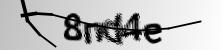

In [385]:
imageList, codeList = getData(1)
x_data = map(imageToVertor, imageList)
y_data = map(codeToVertor, codeList)
p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
print 'code:', codeList[index]
print 'prediction:', map(lambda x: charset[x], p[0])
print 'loss:', l
imageList[0]

#### (2). 实际测试

In [386]:
# url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
# response = requests.get(url)
# image = Image.open(StringIO(response.content))
# imageList, codeList = [image], ['ca358']
# x_data = map(imageToVertor, imageList)
# y_data = map(codeToVertor, codeList)
# p, l = session.run([prediction, loss], feed_dict={x: x_data, y: y_data, keep_prob: .75})
# print 'prediction:', map(lambda x: charset[x], p[0])
# print 'loss:', l
# image

In [ ]:
url = 'https://s.nacao.org.cn/servlet/ValidateCode?time='
response = requests.get(url)
image = Image.open(StringIO(response.content))
imageList = [image]
x_data = map(imageToVertor, imageList)
p = session.run(prediction, feed_dict={x: x_data, keep_prob: 1})
print 'prediction:', map(lambda x: charset[x], p[0])
image